# Illustrate committor active learning with AMS on the MB potential

In [1]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

General imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
import random
def set_all_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
seed = 0 
set_all_seeds(seed)

Using device: cuda


Imports for AMS and potential

In [3]:
from potentials.EntropicSwitchTrippleWellPotential import EntropicSwitchTrippleWellPotential
from simulations.AMSSimulation import AMSOverdampedLangevin

Import for committor learning

In [4]:
from committor.neural_net_models import CommittorMultiDecoder
from committor.train_committor import TainCommittorMultipleDecoder

Define potential and neural net for committor approximation and the corresponding training object 

In [5]:
pot = EntropicSwitchTrippleWellPotential()
pot.set_2D_plot_grid_precision(200, 200)
## Generate 100 penalization points on each boundary of R and P
#theta = np.random.uniform(0,np.pi, size=[100])
#pen_points = np.append(np.append(pot.minR + np.array([pot.R_radius * np.cos(theta), pot.R_radius * np.sin(theta)]).T, np.zeros([100, 1]), axis=1), np.append(pot.minP + np.array([pot.P_radius * np.cos(theta), pot.P_radius * np.sin(theta)]).T, np.ones([100, 1]), axis=1), axis=0)


#committor = torch.load('AMS_xi_comm_ES')
committor = CommittorMultiDecoder([2, 20, 20, 1], [1, 20, 20, 2], pot)

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})

In [6]:
MEP_1 = [pot.minimum_energy_paths[0][0]]
i = 1
while i < len(pot.minimum_energy_paths[0]):
    if np.sqrt(np.sum((MEP_1[-1] - pot.minimum_energy_paths[0][i])**2)) > pot.dx:
        MEP_1.append(pot.minimum_energy_paths[0][i])
    i += 1
MEP_1 = np.array(MEP_1)
MEP_2 = [pot.minimum_energy_paths[1][0]]
i = 1
while i < len(pot.minimum_energy_paths[1]):
    if np.sqrt(np.sum((MEP_2[-1] - pot.minimum_energy_paths[1][i])**2)) > pot.dx:
        MEP_2.append(pot.minimum_energy_paths[1][i])
    i += 1
i = 1
while i < len(pot.minimum_energy_paths[2]):
    if np.sqrt(np.sum((MEP_2[-1] - pot.minimum_energy_paths[2][-i])**2)) > pot.dx:
        MEP_2.append(pot.minimum_energy_paths[2][-i])
    i += 1
MEP_2 = np.array(MEP_2)

Define temperature via $\beta = \left( k_\mathrm{B} T \right)^{-1}$, time step size and AMS simulation object 

In [7]:
beta = 4
dt = 0.01
AMS_on_ES = AMSOverdampedLangevin(pot, xi=None, beta=beta, forward=True, dt=dt, threshold=10**(-8))

Run dynamics to sample intitial conditions in reactant and product metastable state

In [8]:
n_conditions = 20
n_rep = 20
k_min = 1
ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_ES.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_ES.set_forward(False)
ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_ES.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_ES.set_forward(True)
print(n_steps_b + n_steps_f)

946


In [9]:
N = 50 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dataset = {"single_trajs_pos": [], 
           "single_trajs_gauss": [], 
           "single_trajs_weights": [], 
           'dt': dt, 'beta': beta}

i = 0
while i < len(ini_traj_f["x_traj"]) - N:
    x_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_f["x_traj"][i]) or pot.in_R(ini_traj_f["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_f["x_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_f["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_f["x_traj"][n+i:n+i+1]) 
                gauss_traj.append(ini_traj_f["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_f["x_traj"][n+i]) or pot.in_R(ini_traj_f["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_f["x_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_f["x_traj"])
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
i = 0
while i < len(ini_traj_b["x_traj"]) - N:
    x_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_b["x_traj"][i]) or pot.in_R(ini_traj_b["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_b["x_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_b["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_b["x_traj"][n+i:n+i+1]) 
                gauss_traj.append(ini_traj_b["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_b["x_traj"][n+i]) or pot.in_R(ini_traj_b["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_b["x_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_b["x_traj"])
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.array(dataset["single_trajs_weights"])
dataset["single_trajs_gauss"] = np.array(dataset["single_trajs_gauss"])[:, :, 0, :]
dataset["single_trajs_pos"] = np.array(dataset["single_trajs_pos"])[:, :, 0, :]

In [10]:
dataset["single_trajs_pos"].shape

(74, 51, 2)

   Define the committor training object, and prepare training

In [11]:
committor_training = TainCommittorMultipleDecoder(committor, pot, dataset)
committor_training.train_test_split(train_size= 50)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
committor_training.set_optimizer('Adam', 0.001)
loss_params = {}
loss_params["ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 0.0 * 10**0
loss_params["n_wait"] = 50

committor_training.set_loss_weight(loss_params)
batch_size = 10
max_epochs = 1000

log_ito_loss_weight value not provided, set to default value of:  0.0
strahan_loss_weight value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
squared_grad_boltz_weight value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0


Train the committor model 

In [12]:
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 1000 epochs.



Plot results

/tmp/ipykernel_29321/2046264514.py:15: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_29321/2046264514.py:33: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')


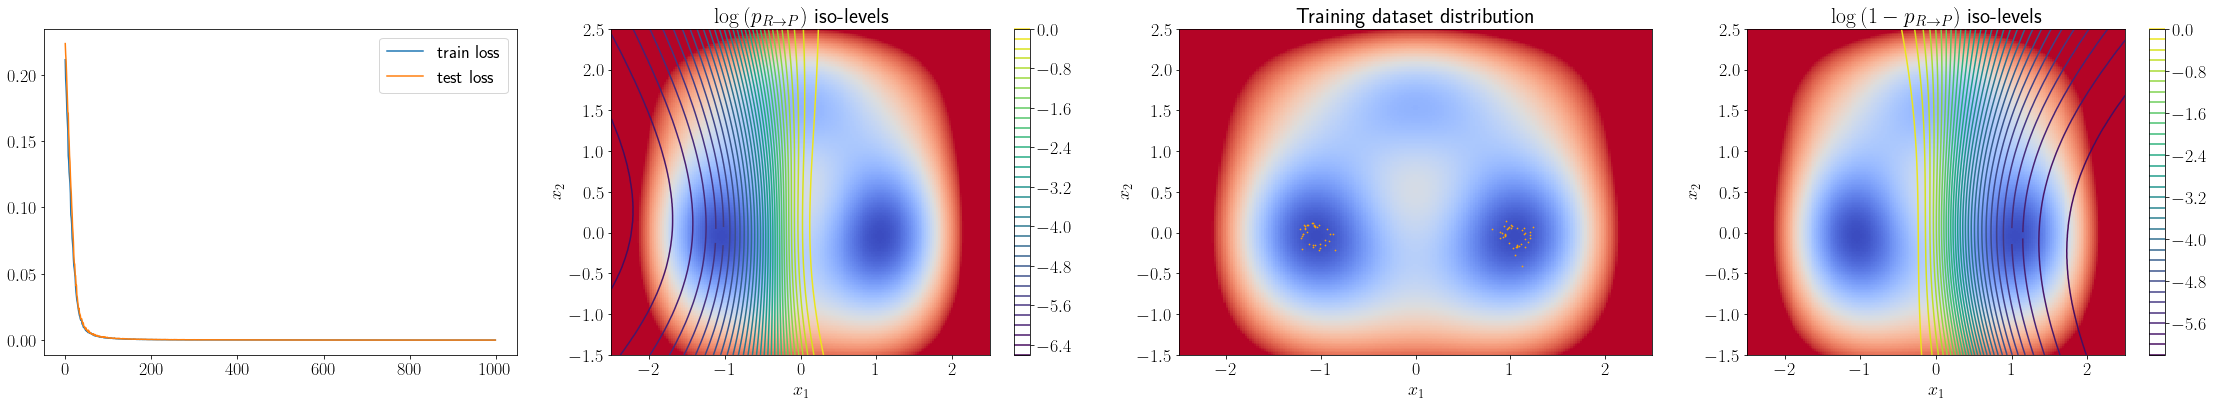

In [13]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([200, 200])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(39, 6)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
#ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title(r'$ \log \left( p_{R\rightarrow P} \right) $ iso-levels')
# dataset distribution 
pot.plot_potential_heat_map(ax2)
#ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')
ax2.set_title(r'Training dataset distribution')

ax2.scatter(committor_training.dataset["single_trajs_pos"][:,0, 0], committor_training.dataset["single_trajs_pos"][:,0,1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
#ax3.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax3.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax3.set_xlabel(r'$x_1$')
ax3.set_ylabel(r'$x_2$')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title(r'$ \log \left(1-p_{R\rightarrow P} \right) $ iso-levels')
plt.savefig("ES_itarative_AMS.png", format='png', dpi=160)

Run AMS forward

/tmp/ipykernel_29321/3151944801.py:6: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')


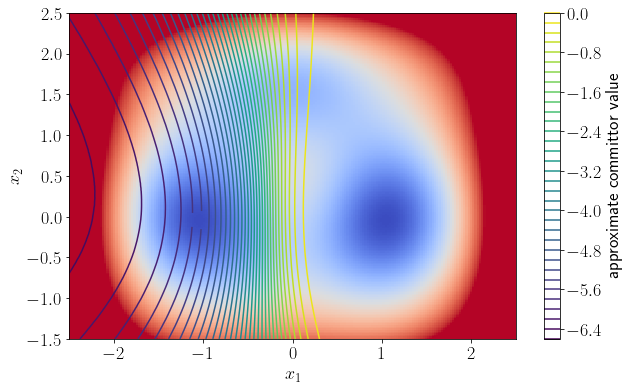

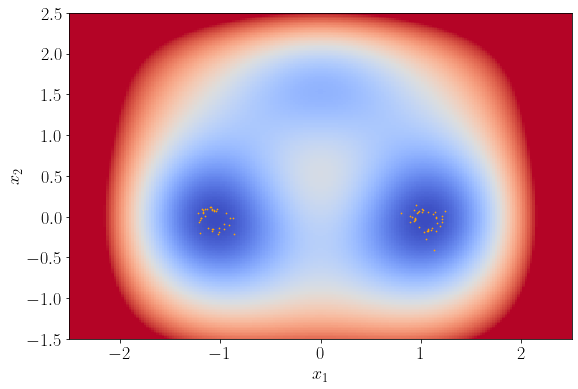

In [14]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6)) 
# log committor plot 
pot.plot_potential_heat_map(ax1)
#ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1, label='approximate committor value') 
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
plt.savefig('first_ES_training_a.png', format='png', dpi=160)

fig, (ax2) = plt.subplots(1, 1, figsize=(9, 6)) 
# dataset distribution 
pot.plot_potential_heat_map(ax2)
#ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.scatter(committor_training.dataset["single_trajs_pos"][:,0, 0], committor_training.dataset["single_trajs_pos"][:,0,1], color='orange', s=0.5)
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')
plt.savefig('first_ES_training_b.png', format='png', dpi=160)

In [15]:
AMS_on_ES.set_xi(committor_training.committor_model.xi_forward)
p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_ES.ams_run(ini_conds_f, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_ES.set_forward(False)
AMS_on_ES.set_xi(committor_training.committor_model.xi_backward)
p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_ES.ams_run(ini_conds_b, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_ES.set_forward(True)

In [16]:
print(p_f)
print(p_b)

8.776124260424812e-06
1.2362304178860644e-05


Add the new sampled trajectories to the dataset

In [17]:
N = 50 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dset = {"single_trajs_pos": [], 
        "single_trajs_gauss": [], 
        "single_trajs_weights": []}
for j in range(0, len(replicas_f)):
    i = 0
    while i < len(replicas_f[j]["x_traj"]) - N:
        x_traj = []
        gauss_traj = []
        while pot.in_P(replicas_f[j]["x_traj"][i]) or pot.in_R(replicas_f[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_f[j]["x_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_f[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_f[j]["x_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_f[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_f[j]["x_traj"][n+i]) or pot.in_R(replicas_f[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_f[j]["x_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_f[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])
for j in range(0, len(replicas_b)):
    i = 0
    while i < len(replicas_b[j]["x_traj"]) - N:
        x_traj = []
        gauss_traj = []
        while pot.in_P(replicas_b[j]["x_traj"][i]) or pot.in_R(replicas_b[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_b[j]["x_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_b[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_b[j]["x_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_b[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_b[j]["x_traj"][n+i]) or pot.in_R(replicas_b[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_b[j]["x_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_b[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])

In [18]:
dataset["single_trajs_weights"] = np.append(dataset["single_trajs_weights"], np.array(dset["single_trajs_weights"]), axis=0)
dataset["single_trajs_gauss"] = np.append(dataset["single_trajs_gauss"], np.array(dset["single_trajs_gauss"])[:, :, 0, :], axis=0)
dataset["single_trajs_pos"] = np.append(dataset["single_trajs_pos"], np.array(dset["single_trajs_pos"])[:, :, 0, :], axis=0)

In [19]:
dataset["single_trajs_pos"].shape

(953, 51, 2)

Re-set the training dataset and train again 

In [20]:
committor_training.set_dataset(dataset)
committor_training.train_test_split(train_size= 25 * 10**1)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
committor_training.set_optimizer('Adam', 0.001)
batch_size = 10**2
max_epochs = 10000
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 556 epochs.



Plot the results 

/tmp/ipykernel_29321/1392728818.py:12: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_29321/1392728818.py:26: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')


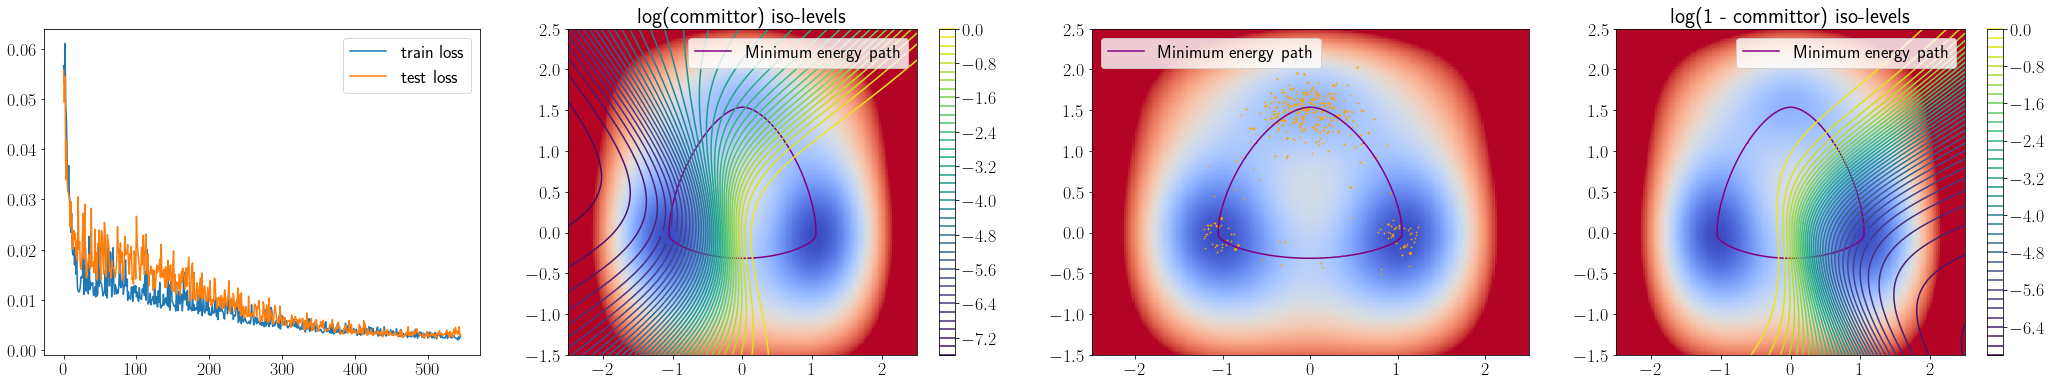

In [21]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([200, 200])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(36, 6)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][10:], label='train loss')
ax0.plot(loss_dict["test_loss"][10:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax1.legend()
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.scatter(committor_training.dataset["single_trajs_pos"][:,0, 0], committor_training.dataset["single_trajs_pos"][:,0,1], color='orange', s=0.5)
ax2.legend()

# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax3.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")
ax3.legend()

/tmp/ipykernel_29321/1811676113.py:6: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')


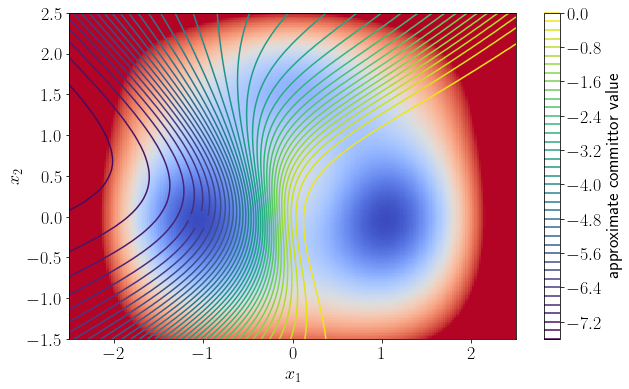

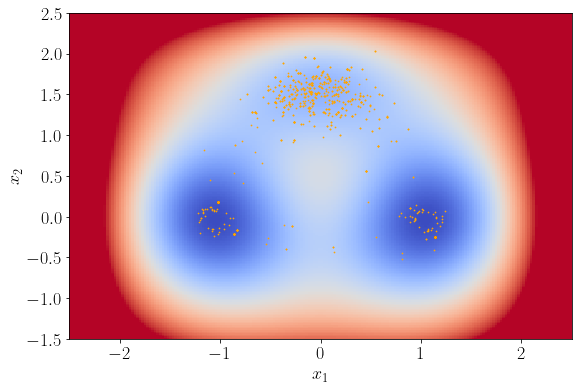

In [22]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6)) 
# log committor plot 
pot.plot_potential_heat_map(ax1)
#ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1, label='approximate committor value') 
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
plt.savefig('second_ES_training_a.png', format='png', dpi=160)

fig, (ax2) = plt.subplots(1, 1, figsize=(9, 6)) 
# dataset distribution 
pot.plot_potential_heat_map(ax2)
#ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.scatter(committor_training.dataset["single_trajs_pos"][:,0, 0], committor_training.dataset["single_trajs_pos"][:,0,1], color='orange', s=0.5)
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')
plt.savefig('second_ES_training_b.png', format='png', dpi=160)

Test the quality with the reference from finite elements method.

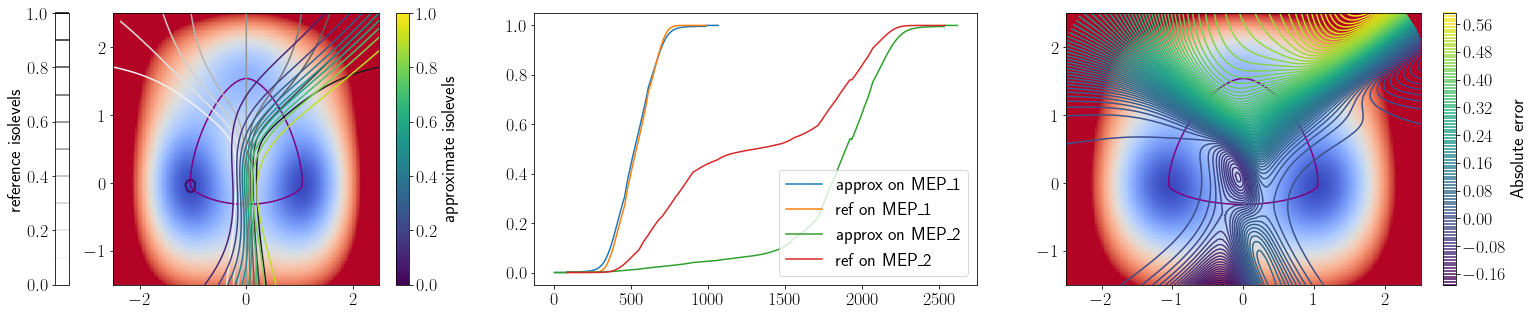

In [24]:
pts = np.loadtxt('ES_pts.csv', delimiter=',', dtype=float)
tri = np.loadtxt('ES_tri.csv', delimiter=',', dtype=int)
q = np.loadtxt('ES_comm.txt', dtype=float)
from matplotlib.tri import Triangulation, TriFinder, LinearTriInterpolator
triangulation = Triangulation(pts[:,0], pts[:,1], tri)
interp = LinearTriInterpolator(triangulation, q, trifinder=triangulation.get_trifinder())

ref_committor_x2d = interp._interpolate_multikeys(x=pot.x2d[:,0], y=pot.x2d[:,1], tri_index=None, return_keys=('z',))[0].data.reshape(pot.n_bins_x, pot.n_bins_y)
committor_on_x2d = committor_training.committor_model.xi_forward(pot.x2d).reshape(pot.n_bins_x, pot.n_bins_y)

fig, (ax1, ax0, ax2) = plt.subplots(1, 3, figsize=(27, 5)) 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), cmap='Greys')
contour2 = committor_training.plot_committor_iso_levels(ax1, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), set_lim=False)
fig.colorbar(contour1, ax=ax1, label="reference isolevels", location="left") 
fig.colorbar(contour2, ax=ax1, label="approximate isolevels", location="right") 

pot.plot_potential_heat_map(ax2)
ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour = ax2.contour(pot.x_plot, pot.y_plot, ref_committor_x2d - committor_on_x2d, 100, cmap='viridis')
fig.colorbar(contour, ax=ax2, label="Absolute error") 

ref_committor_MEP1 = interp._interpolate_multikeys(x=MEP_1[:, 0], y=MEP_1[:, 1], tri_index=None, return_keys=('z',))[0]
ref_committor_MEP2 = interp._interpolate_multikeys(x=MEP_2[:, 0], y=MEP_2[:, 1], tri_index=None, return_keys=('z',))[0]
committor_on_MEP1 = committor_training.committor_model.xi_forward(MEP_1)
committor_on_MEP2 = committor_training.committor_model.xi_forward(MEP_2)


ax0.plot(committor_on_MEP1, label="approx on MEP_1")
ax0.plot(ref_committor_MEP1, label="ref on MEP_1")
ax0.plot(committor_on_MEP2, label="approx on MEP_2")
ax0.plot(ref_committor_MEP2, label="ref on MEP_2")
#ax0.plot(err_MEP, label="error on MEP2")
ax0.legend()

In [25]:
# Compute RMSE on a sample of 1000 configurations distributed according ot the reactive trajectories measure. 
react = np.loadtxt('react_trajs_ES.txt')

ref_committor_react = interp._interpolate_multikeys(x=react[:,0], y=react[:,1], tri_index=None, return_keys=('z',))[0]
app_committor_react = committor_training.committor_model.xi_forward(react)[:, 0]
RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
print("RMSE react = ", RMSE)
committor_training.print_test_loss(batch_size=10)

RMSE react =  0.3725273828306533
Test loss:  0.0035538385
Test ito loss:  0.0035538385
Test log ito loss:  0.53120846


## New iteration of the learning procedure. 

store the old values of the approximate committor 

In [26]:
app_committor_react_old = app_committor_react.copy()

Sample some new initial conditions 

In [30]:
n_conditions = 20
n_rep = 20
k_min = 1
ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_ES.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_ES.set_forward(False)
ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_ES.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_ES.set_forward(True)
print(n_steps_b + n_steps_f)

716


Add to the dataset

In [31]:
N = 50 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dset = {"single_trajs_pos": [], 
        "single_trajs_gauss": [], 
        "single_trajs_weights": []}

i = 0
while i < len(ini_traj_f["x_traj"]) - N:
    x_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_f["x_traj"][i]) or pot.in_R(ini_traj_f["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_f["x_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_f["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_f["x_traj"][n+i:n+i+1]) 
                gauss_traj.append(ini_traj_f["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_f["x_traj"][n+i]) or pot.in_R(ini_traj_f["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_f["x_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_f["x_traj"])
    dset["single_trajs_pos"].append(x_traj)
    dset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dset["single_trajs_weights"].append([boudary_weight])
    else:
        dset["single_trajs_weights"].append([1.])
i = 0
while i < len(ini_traj_b["x_traj"]) - N:
    x_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_b["x_traj"][i]) or pot.in_R(ini_traj_b["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_b["x_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_b["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_b["x_traj"][n+i:n+i+1]) 
                gauss_traj.append(ini_traj_b["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_b["x_traj"][n+i]) or pot.in_R(ini_traj_b["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_b["x_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_f["x_traj"])
    dset["single_trajs_pos"].append(x_traj)
    dset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dset["single_trajs_weights"].append([boudary_weight])
    else:
        dset["single_trajs_weights"].append([1.])

In [32]:
dataset["single_trajs_weights"] = np.append(dataset["single_trajs_weights"], np.array(dset["single_trajs_weights"]), axis=0)
dataset["single_trajs_gauss"] = np.append(dataset["single_trajs_gauss"], np.array(dset["single_trajs_gauss"])[:, :, 0, :], axis=0)
dataset["single_trajs_pos"] = np.append(dataset["single_trajs_pos"], np.array(dset["single_trajs_pos"])[:, :, 0, :], axis=0)

In [40]:
dataset["single_trajs_pos"].shape

(1022, 51, 2)

Run AMS again 

In [41]:
committor_training.committor_model.to('cuda:0')
AMS_on_ES.set_xi(committor_training.committor_model.xi_forward)
p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_ES.ams_run(ini_conds_f, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_ES.set_forward(False)
AMS_on_ES.set_xi(committor_training.committor_model.xi_backward)
p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_ES.ams_run(ini_conds_b, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_ES.set_forward(True)

In [42]:
print(p_f)
print(p_b)

5.977090182880148e-06
9.607335175042204e-06


Add sampled trajectories data to dataset 

In [43]:
N = 50 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dset = {"single_trajs_pos": [], 
        "single_trajs_gauss": [], 
        "single_trajs_weights": []}
for j in range(0, len(replicas_f)):
    i = 0
    while i < len(replicas_f[j]["x_traj"]) - N:
        x_traj = []
        gauss_traj = []
        while pot.in_P(replicas_f[j]["x_traj"][i]) or pot.in_R(replicas_f[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_f[j]["x_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_f[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_f[j]["x_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_f[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_f[j]["x_traj"][n+i]) or pot.in_R(replicas_f[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_f[j]["x_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_f[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])
for j in range(0, len(replicas_b)):
    i = 0
    while i < len(replicas_b[j]["x_traj"]) - N:
        x_traj = []
        gauss_traj = []
        while pot.in_P(replicas_b[j]["x_traj"][i]) or pot.in_R(replicas_b[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_b[j]["x_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_b[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_b[j]["x_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_b[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_b[j]["x_traj"][n+i]) or pot.in_R(replicas_b[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_b[j]["x_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_b[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])

In [44]:
dataset["single_trajs_weights"] = np.append(dataset["single_trajs_weights"], np.array(dset["single_trajs_weights"]), axis=0)
dataset["single_trajs_gauss"] = np.append(dataset["single_trajs_gauss"], np.array(dset["single_trajs_gauss"])[:, :, 0, :], axis=0)
dataset["single_trajs_pos"] = np.append(dataset["single_trajs_pos"], np.array(dset["single_trajs_pos"])[:, :, 0, :], axis=0)

In [45]:
dataset["single_trajs_pos"].shape

(2060, 51, 2)

In [46]:
del(committor) ## In case you want to restart from here at a certain point
del(committor_training)
committor = CommittorMultiDecoder([2, 20, 20, 1], [1, 20, 20, 2], pot)
committor_training = TainCommittorMultipleDecoder(committor, pot, dataset, eps=1*10**(-2))
loss_params = {}
loss_params["log_ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 0.0 * 10**0
loss_params["mse_react_weight"] = 0.0 * 10**0
loss_params["n_wait"] = 50
committor_training.set_loss_weight(loss_params)

ito_loss_weight value not provided, set to default value of:  0.0
strahan_loss_weight value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
squared_grad_boltz_weight value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0


Re-train

In [47]:
committor_training.set_dataset(dataset)
committor_training.train_test_split(train_size=20 * 10**2)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
committor_training.set_optimizer('Adam', 0.001, parameters_to_train="all")
batch_size = 1 * 10**2
max_epochs = 10000
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 363 epochs.



/tmp/ipykernel_29321/939071296.py:13: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_29321/939071296.py:27: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')


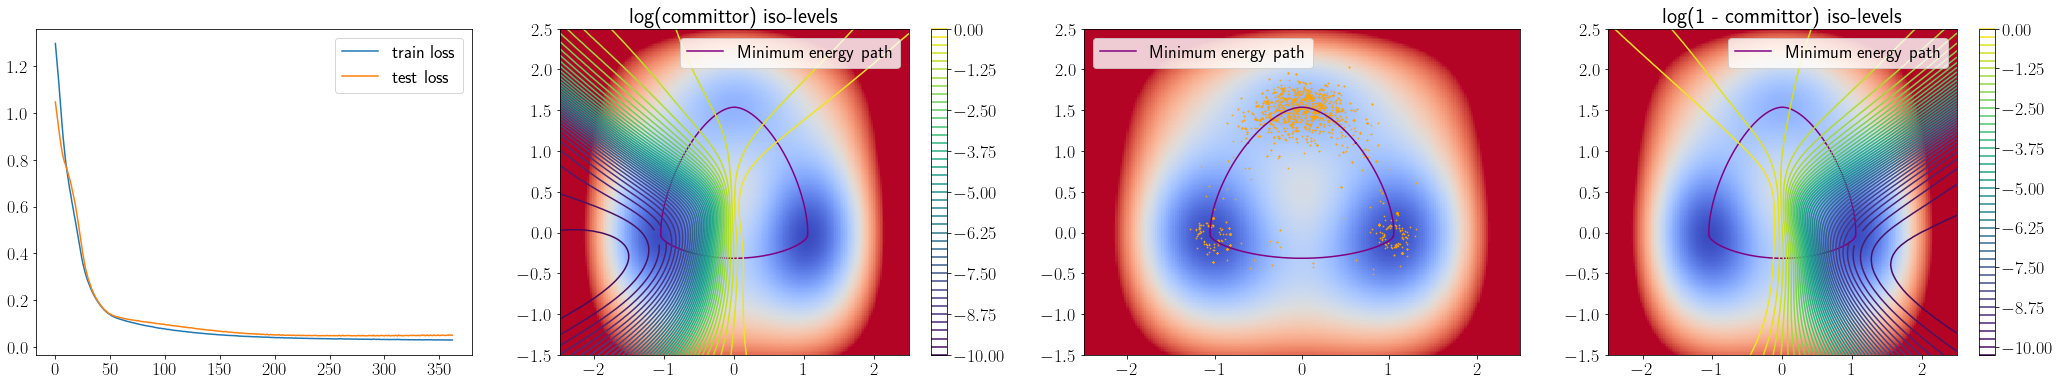

In [48]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([200, 200])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(36, 6)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax1.legend()

contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.scatter(committor_training.dataset["single_trajs_pos"][:,0, 0], committor_training.dataset["single_trajs_pos"][:,0,1], color='orange', s=0.5)
ax2.legend()

# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax3.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")
ax3.legend()

Plot figures to compare to the finite element reference

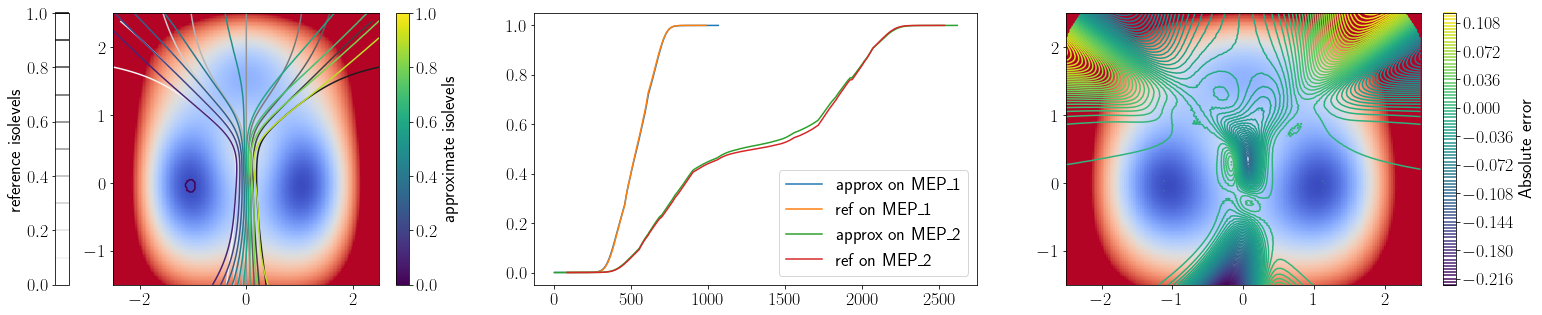

In [49]:
pts = np.loadtxt('ES_pts.csv', delimiter=',', dtype=float)
tri = np.loadtxt('ES_tri.csv', delimiter=',', dtype=int)
q = np.loadtxt('ES_comm.txt', dtype=float)
from matplotlib.tri import Triangulation, TriFinder, LinearTriInterpolator
triangulation = Triangulation(pts[:,0], pts[:,1], tri)
interp = LinearTriInterpolator(triangulation, q, trifinder=triangulation.get_trifinder())

ref_committor_x2d = interp._interpolate_multikeys(x=pot.x2d[:,0], y=pot.x2d[:,1], tri_index=None, return_keys=('z',))[0].data.reshape(pot.n_bins_x, pot.n_bins_y)
committor_on_x2d = committor_training.committor_model.xi_forward(pot.x2d).reshape(pot.n_bins_x, pot.n_bins_y)

fig, (ax1, ax0, ax2) = plt.subplots(1, 3, figsize=(27, 5)) 
pot.plot_potential_heat_map(ax1)
#ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), cmap='Greys')
contour2 = committor_training.plot_committor_iso_levels(ax1, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), set_lim=False)
fig.colorbar(contour1, ax=ax1, label="reference isolevels", location="left") 
fig.colorbar(contour2, ax=ax1, label="approximate isolevels", location="right") 

pot.plot_potential_heat_map(ax2)
#ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour = ax2.contour(pot.x_plot, pot.y_plot, ref_committor_x2d - committor_on_x2d, 100, cmap='viridis')
fig.colorbar(contour, ax=ax2, label="Absolute error") 

ref_committor_MEP1 = interp._interpolate_multikeys(x=MEP_1[:, 0], y=MEP_1[:, 1], tri_index=None, return_keys=('z',))[0]
ref_committor_MEP2 = interp._interpolate_multikeys(x=MEP_2[:, 0], y=MEP_2[:, 1], tri_index=None, return_keys=('z',))[0]
committor_on_MEP1 = committor_training.committor_model.xi_forward(MEP_1)
committor_on_MEP2 = committor_training.committor_model.xi_forward(MEP_2)


ax0.plot(committor_on_MEP1, label="approx on MEP_1")
ax0.plot(ref_committor_MEP1, label="ref on MEP_1")
ax0.plot(committor_on_MEP2, label="approx on MEP_2")
ax0.plot(ref_committor_MEP2, label="ref on MEP_2")
ax0.legend()

Compute root mean squarred error of with respect to finite elements method solution on 1000 points sampled from the reactive trajectories density measure.  

In [50]:
react = np.loadtxt('react_trajs_ES.txt')

ref_committor_react = interp._interpolate_multikeys(x=react[:,0], y=react[:,1], tri_index=None, return_keys=('z',))[0]
app_committor_react = committor_training.committor_model.xi_forward(react)[:, 0]
RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
print("RMSE react = ", RMSE)
committor_training.print_test_loss(batch_size=100)

RMSE react =  0.014227885680503642
Test loss:  0.046192244
Test ito loss:  0.0014706813
Test log ito loss:  0.046192244


In [51]:
from sklearn.metrics import r2_score

x = app_committor_react
y = app_committor_react_old
A = np.vstack([x, np.ones(len(x))]).T

coefs, r, rank ,s = np.linalg.lstsq(A, y, rcond=None)
print("Regression score = ", r2_score(app_committor_react, app_committor_react_old))

Regression score =  -2.7488337876123494


# Train the decoders to identify two clusters in the reactive trajectory density 

In [52]:
n_conditions = 100
n_rep = 100
k_min = 1
committor_training.committor_model.to('cuda:0')
AMS_on_MB.set_xi(committor_training.committor_model.xi_forward)
ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_MB.ams_run(ini_conds_f, n_rep, k_min, return_all=False, save_gauss=True)
AMS_on_MB.set_forward(False)
AMS_on_MB.set_xi(committor_training.committor_model.xi_backward)
ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_MB.ams_run(ini_conds_b, n_rep, k_min, return_all=False, save_gauss=True)
AMS_on_MB.set_forward(True)

### New dataset with longer trajectories once a "decent" committor approx is available 

In [ ]:
N = 150 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dataset = {"single_trajs_pos": [], 
           "single_trajs_gauss": [], 
           "single_trajs_weights": [], 
           'dt': dt, 'beta': beta}

i = 0
while i < len(ini_traj_f["x_traj"]) - N:
    x_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_f["x_traj"][i]) or pot.in_R(ini_traj_f["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_f["x_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_f["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_f["x_traj"][n+i:n+i+1]) 
                gauss_traj.append(ini_traj_f["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_f["x_traj"][n+i]) or pot.in_R(ini_traj_f["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_f["x_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_f["x_traj"])
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
i = 0
while i < len(ini_traj_b["x_traj"]) - N:
    x_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_b["x_traj"][i]) or pot.in_R(ini_traj_b["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_b["x_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_b["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_b["x_traj"][n+i:n+i+1]) 
                gauss_traj.append(ini_traj_b["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_b["x_traj"][n+i]) or pot.in_R(ini_traj_b["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_b["x_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_f["x_traj"])
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.array(dataset["single_trajs_weights"])
dataset["single_trajs_gauss"] = np.array(dataset["single_trajs_gauss"])[:, :, 0, :]
dataset["single_trajs_pos"] = np.array(dataset["single_trajs_pos"])[:, :, 0, :]

In [ ]:
N = 150 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dset = {"single_trajs_pos": [], 
        "single_trajs_gauss": [], 
        "single_trajs_weights": []}
for j in range(0, len(replicas_f)):
    i = 0
    while i < len(replicas_f[j]["x_traj"]) - N:
        x_traj = []
        gauss_traj = []
        while pot.in_P(replicas_f[j]["x_traj"][i]) or pot.in_R(replicas_f[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_f[j]["x_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_f[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_f[j]["x_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_f[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_f[j]["x_traj"][n+i]) or pot.in_R(replicas_f[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_f[j]["x_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_f[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])
for j in range(0, len(replicas_b)):
    i = 0
    while i < len(replicas_b[j]["x_traj"]) - N:
        x_traj = []
        gauss_traj = []
        while pot.in_P(replicas_b[j]["x_traj"][i]) or pot.in_R(replicas_b[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_b[j]["x_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_b[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_b[j]["x_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_b[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_b[j]["x_traj"][n+i]) or pot.in_R(replicas_b[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_b[j]["x_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_b[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.append(dataset["single_trajs_weights"], np.array(dset["single_trajs_weights"]), axis=0)
dataset["single_trajs_gauss"] = np.append(dataset["single_trajs_gauss"], np.array(dset["single_trajs_gauss"])[:, :, 0, :], axis=0)
dataset["single_trajs_pos"] = np.append(dataset["single_trajs_pos"], np.array(dset["single_trajs_pos"])[:, :, 0, :], axis=0)

In [ ]:
dataset["single_trajs_pos"].shape

### Box to gather all the structures within reactive trajectories.

In [53]:
react_trajs = replicas_b[-n_rep]["x_traj"]
for i in range(1, n_rep):
    react_trajs = np.append(react_trajs, replicas_b[-i]["x_traj"], axis=0)
for i in range(len(replicas_f)):
    react_trajs = np.append(react_trajs, replicas_f[-i]["x_traj"], axis=0)    
print(react_trajs.shape)


(74690, 2)


In [79]:
ds  = {"react_pos":react_trajs,
       "react_weights": np.ones([len(react_trajs),1]),
       "beta" : beta, "dt" : dt}

In [80]:
#del(committor) ## In case you want to restart from here at a certain point
#del(committor_training)
#committor = CommittorTwoDecoder([2, 5, 5, 1], [1, 20, 20, 2], 0, pot)
committor_training = TainCommittorMultipleDecoder(committor, pot, ds)
committor_training.set_optimizer('Adam', 0.001, parameters_to_train="decoders")
loss_params = {}
loss_params["ito_loss_weight"] = 0.0
loss_params["pen_points_weight"] = 0.0 * 10**(0)
loss_params["mse_react_weight"] = 1.0 * 10**(0)
loss_params["n_wait"] = 50
committor_training.set_loss_weight(loss_params)

log_ito_loss_weight value not provided, set to default value of:  0.0
strahan_loss_weight value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
squared_grad_boltz_weight value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0


In [83]:
committor_training.committor_model.encoder.to('cuda:0')
committor_training.committor_model.decoders[0].to('cuda:0')
committor_training.committor_model.decoders[1].to('cuda:0')
committor_training.train_test_split(train_size=2 * 10**4)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
batch_size = 1 * 10**3
max_epochs = 10000
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 2857 epochs.



/tmp/ipykernel_29321/2903464401.py:13: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_29321/2903464401.py:27: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')


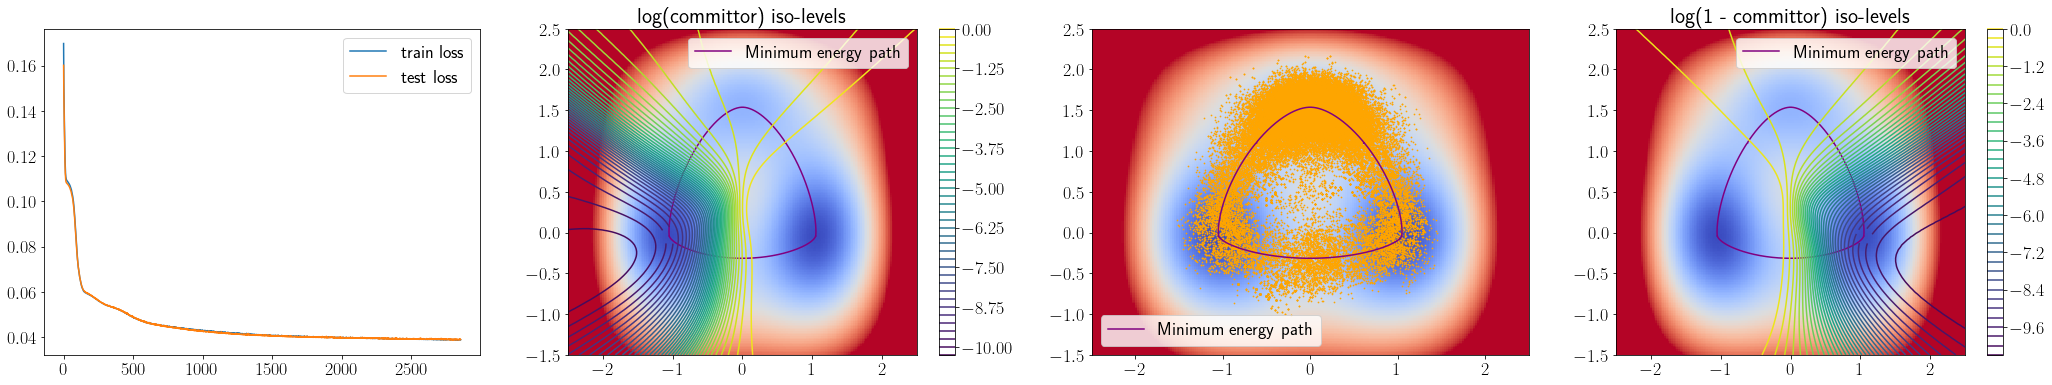

In [84]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([200, 200])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(36, 6)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax1.legend()

contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.scatter(committor_training.dataset["react_pos"][:, 0], committor_training.dataset["react_pos"][:, 1], color='orange', s=0.5)
ax2.legend()

# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax3.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")
ax3.legend()

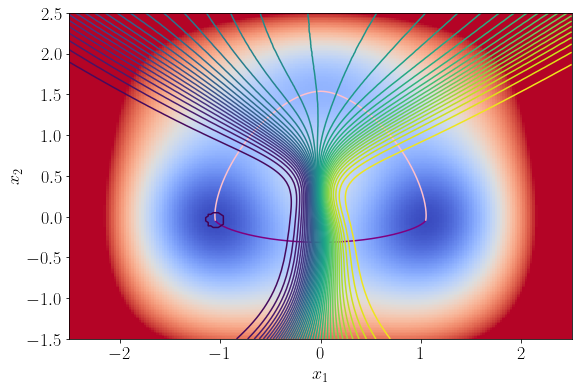

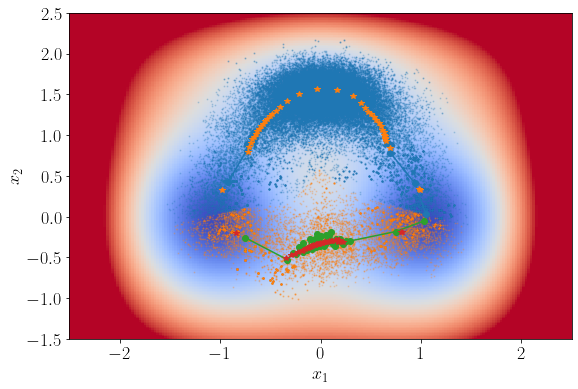

In [107]:
react_points = torch.tensor(committor_training.dataset["react_pos"].astype('float32'), device='cuda:0')
react_points_decoded1 = committor_training.committor_model.decoders[0](committor_training.committor_model.encoder(react_points))
react_points_decoded2 = committor_training.committor_model.decoders[1](committor_training.committor_model.encoder(react_points))
x1 = torch.sum((react_points - react_points_decoded1) ** 2, dim=1).cpu().detach().numpy() < torch.sum(
            (react_points - react_points_decoded2) ** 2,
            dim=1).cpu().detach().numpy()
x2 = torch.sum((react_points - react_points_decoded2) ** 2, dim=1).cpu().detach().numpy() < torch.sum(
            (react_points - react_points_decoded1) ** 2,
            dim=1).cpu().detach().numpy()

xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([200, 200])

fig, (ax0) = plt.subplots(1, 1, figsize=(9, 6)) 
pot.plot_potential_heat_map(ax0)
ax0.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax0.plot(MEP_2[:,0], MEP_2[:,1], color='pink')
ax0.set_xlabel(r'$x_1$')
ax0.set_ylabel(r'$x_2$')
#ax0.legend()
committor_training.plot_committor_iso_levels(ax0, 40, set_lim=False)

plt.savefig('ES_AMS_result_clust_a.png', format='png', dpi=160)


fig, (ax1) = plt.subplots(1, 1, figsize=(9, 6)) 
pot.plot_potential_heat_map(ax1)
n_bins=40
X_given_z = [[[] for i in range(n_bins)] for j in range(len(committor_training.committor_model.decoders))]
Esp_X_given_z = [[] for i in range(len(committor_training.committor_model.decoders))]
f_dec_z = [[] for i in range(len(committor_training.committor_model.decoders))]
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

points = torch.tensor(committor_training.dataset["react_pos"].astype('float32'), device=device)

points_decoded = torch.stack([dec(committor_training.committor_model.encoder(points)) for dec in committor_training.committor_model.decoders])
error = torch.sum((points_decoded - points) ** 2, dim=2).cpu().detach().numpy()
where = error <= np.min(error, axis=0)
xi_values = committor_training.committor_model.xi_forward(points)[:, 0]
# equal-width bins
z_bin = np.linspace(xi_values.min(), xi_values.max(), n_bins)

# compute index of bin
inds = np.digitize(xi_values, z_bin)
# distribute train data to each bin
non_empty_clusters = []
for i in range(len(committor_training.committor_model.decoders)):
    for bin_idx in range(n_bins):
        X_given_z[i][bin_idx] = committor_training.dataset["react_pos"][where[i] * (inds == bin_idx + 1), :2]
        if len(X_given_z[i][bin_idx]) > 0:
            Esp_X_given_z[i].append(torch.tensor(X_given_z[i][bin_idx].astype('float32'), device="cuda:0").mean(dim=0))
            f_dec_z[i].append(committor_training.committor_model.decoders[i](committor_training.committor_model.encoder(Esp_X_given_z[i][-1])).cpu().detach().numpy())
            Esp_X_given_z[i][-1] = Esp_X_given_z[i][-1].cpu().detach().numpy()
    Esp_X_given_z[i] = np.array(Esp_X_given_z[i])
    f_dec_z[i] = np.array(f_dec_z[i])
    if Esp_X_given_z[i].shape[0] > 0:
        non_empty_clusters.append(i)

for i in non_empty_clusters:
    ax1.plot(Esp_X_given_z[i][:, 0], Esp_X_given_z[i][:, 1], '-o', label='cond. avg. decoder ' + str(i))
    ax1.scatter(points.cpu()[where[i]][:, 0],
                points.cpu()[where[i]][:, 1],
                label='cluster ' + str(i),
                s=1,
                alpha=0.2)
    ax1.plot(f_dec_z[i][:, 0], f_dec_z[i][:, 1], '*', label='decoder ' + str(i))

#z_bin, Esp_X_given_z, f_dec_z = committor_training.plot_conditional_averages(ax1, n_bins=40, set_lim=False, with_react_dens=True, z_minmax=None)
#ax1.scatter(committor_training.dataset["react_pos"][x1][:, 0], committor_training.dataset["react_pos"][x1][:, 1], color='blue', s=1.5, alpha=0.2)
#ax1.scatter(committor_training.dataset["react_pos"][x2][:, 0], committor_training.dataset["react_pos"][x2][:, 1], color='purple',s=1.5, alpha=0.2)
#ax1.plot(MEP_1[:, 0], MEP_1[:, 1], color='orange', label='Minimum energy path')
#ax1.plot(MEP_2[:, 0], MEP_2[:, 1], color='orange')
#committor_training.plot_conditional_averages(ax1, 40)
#committor_training.plot_committor_iso_levels(ax1, 40, set_lim=False)
#ax1.plot(Esp_X_given_z1[:, 0], Esp_X_given_z1[:, 1], '-o', color='midnightblue', label='cond. avg. decoder 1')
#ax1.plot(Esp_X_given_z2[:, 0], Esp_X_given_z2[:, 1], '-o', color='brown', label='cond. avg. decoder 2')
#ax1.plot(f_dec_z1[:, 0], f_dec_z1[:, 1], '-*', color='black', label='decoder 1')
#ax1.plot(f_dec_z2[:, 0], f_dec_z2[:, 1], '-*', color='pink', label='decoder 2')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
#ax1.legend()
plt.savefig('ES_AMS_result_clust_b.png', format='png', dpi=160)

#ax1.legend()

In [ ]:
## Box to save a sub-sample of reactive trajectories sampled by AMS
size = 1 * 10**3

indices = np.random.choice(len(react_trajs), size=size)
react = react_trajs[indices][:, :2]

fig, (ax0) = plt.subplots(1, 1, figsize=(6, 4)) 
pot.plot_potential_heat_map(ax0)
ax0.plot(MEP_1[:, 0], MEP_1[:, 1], color='purple', label='Minimum energy path')
ax0.plot(MEP_2[:, 0], MEP_2[:, 1], color='purple')
ax0.scatter(react[:, 0], react[:, 1], color='orange', s=0.5)
print(react.shape)

In [ ]:
np.savetxt('react_trajs_ES.txt', react)
#np.savetxt('ES_react_dens.txt', react)

In [ ]:
def xi_x_forward(x):
    return x[:, 0]

def xi_x_backward(x):
    return 1 - x[:, 0]

In [ ]:
pts = np.loadtxt('ES_pts.csv', delimiter=',', dtype=float)
tri = np.loadtxt('ES_tri.csv', delimiter=',', dtype=int)
q = np.loadtxt('ES_comm.txt', dtype=float)
from matplotlib.tri import Triangulation, TriFinder, LinearTriInterpolator
triangulation = Triangulation(pts[:,0], pts[:,1], tri)
interp = LinearTriInterpolator(triangulation, q, trifinder=triangulation.get_trifinder())

def xi_comm_fem_forward(x):
    return interp._interpolate_multikeys(x=x[:,0], y=x[:,1], tri_index=None, return_keys=('z',))[0][0]

def xi_comm_fem_backward(x):
    return 1 - interp._interpolate_multikeys(x=x[:,0], y=x[:,1], tri_index=None, return_keys=('z',))[0][0]

In [ ]:
m_real = 200
n_conditions = 100
n_rep = 100
k_min = 1
AMS_on_MB.set_xi(xi_x_forward)
p_forward = []
for i in range(m_real):
    ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_MB.ams_run(ini_conds_f, n_rep, k_min, return_all=False, save_gauss=True)
    p_forward.append(p_f)
AMS_on_MB.set_forward(False)
AMS_on_MB.set_xi(xi_x_backward)
p_backward = []
for i in range(m_real):
    ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_MB.ams_run(ini_conds_b, n_rep, k_min, return_all=False, save_gauss=True)
    p_backward.append(p_b)
AMS_on_MB.set_forward(True)

print("""with x""") 
print("""var forward : """, np.var(p_forward, ddof=1))
print("""mean forward : """, np.mean(p_forward))
print("""std forward : """, np.std(p_forward, ddof=1))
print("""var backward : """, np.var(p_backward, ddof=1))
print("""mean backward : """, np.mean(p_backward))
print("""std backward : """, np.std(p_backward, ddof=1))

In [ ]:
m_real = 200
n_conditions = 100
n_rep = 100
k_min = 1
AMS_on_MB.set_xi(committor_training.committor_model.xi_forward)
p_forward = []
for i in range(m_real):
    ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_MB.ams_run(ini_conds_f, n_rep, k_min, return_all=False, save_gauss=True)
    p_forward.append(p_f)
AMS_on_MB.set_forward(False)
AMS_on_MB.set_xi(committor_training.committor_model.xi_backward)
p_backward = []
for i in range(m_real):
    ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_MB.ams_run(ini_conds_b, n_rep, k_min, return_all=False, save_gauss=True)
    p_backward.append(p_b)
AMS_on_MB.set_forward(True)

print("""with approx committor""") 
print("""var forward : """, np.var(p_forward, ddof=1))
print("""mean forward : """, np.mean(p_forward))
print("""std forward : """, np.std(p_forward, ddof=1))
print("""var backward : """, np.var(p_backward, ddof=1))
print("""mean backward : """, np.mean(p_backward))
print("""std backward : """, np.std(p_backward, ddof=1))

In [ ]:
AMS_on_MB.set_xi(xi_comm_fem_forward)
p_forward = []
for i in range(m_real):
    ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_MB.ams_run(ini_conds_f, n_rep, k_min, return_all=False, save_gauss=True)
    p_forward.append(p_f)
AMS_on_MB.set_forward(False)
AMS_on_MB.set_xi(xi_comm_fem_backward)
p_backward = []
for i in range(m_real):
    ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_MB.ams_run(ini_conds_b, n_rep, k_min, return_all=False, save_gauss=True)
    p_backward.append(p_b)
AMS_on_MB.set_forward(True)


print("""with fem committor""") 
print("""var forward : """, np.var(p_forward, ddof=1))
print("""mean forward : """, np.mean(p_forward))
print("""std forward : """, np.std(p_forward, ddof=1))
print("""var backward : """, np.var(p_backward, ddof=1))
print("""mean backward : """, np.mean(p_backward))
print("""std backward : """, np.std(p_backward, ddof=1))

In [ ]:
torch.save(committor_training.committor_model, "AMS_xi_comm_ES")